In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
sys.path.append('/home/jma819/post_cmfe_analysis')
#sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
import miniscope_analysis as ma
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf
import scipy.spatial.distance as dist
import itertools
import math
import warnings
warnings.filterwarnings(action='once')

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
reload(utils_jjm)
reload(dlc_utils)

<module 'dlc_utils' from '/home/jma819/post_cmfe_analysis/dlc_utils.py'>

In [3]:
#cnmfe_file_key = pd.read_csv('/volumes/My_Passport/dlc_analysis/behavcamvideos/cnmfe_file_key.csv')
cnmfe_file_key = pd.read_csv('/projects/p30771/dlc_analysis/openfield_dlc_output/cnmfe_file_key.csv')

In [4]:
#cnmfe_base_dir = '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/'
cnmfe_base_dir = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/'
wt_CNMFE_file = ['30-Mar_20_39_05_out.mat', '30-Mar_20_45_16_out.mat', '27-Feb_17_33_59_out.mat', '22-Mar_22_52_02_out.mat',
                 '28-Feb_16_10_05_out.mat', '27-Feb_17_32_15_out.mat', '28-Feb_16_21_21_out.mat', '25-Mar_13_27_27_out.mat',
                 '25-Mar_14_22_02_out.mat', '25-Mar_14_22_44_out.mat', '26-Mar_18_33_55_out.mat', '27-Mar_00_26_12_out.mat', '27-Mar_00_48_46_out.mat']

ko_CNMFE_files = ['31-Mar_13_28_15_out.mat', '29-Mar_21_42_20_out.mat', '13-Apr_17_57_40_out.mat', '29-Mar_14_27_55_out.mat', '13-Apr_16_01_20_out.mat',
                 '13-Apr_16_11_27_out.mat', '29-Mar_13_39_44_out.mat']

In [5]:
#tracking_files = ['/volumes/My_Passport/dlc_analysis/behavcamvideos/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 
tracking_files = ['/projects/p30771/dlc_analysis/openfield_dlc_output/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 

In [6]:
CNMFE_dir_paths_list = [str(cnmfe_base_dir+fname) for fname in wt_CNMFE_file]
#CNMFE_dir_paths_list

In [7]:
binning_time = 1 # seconds 
body_part_for_tracking = 'tail_base' #
number_of_bins = 50 #
polynomial_degree = 2 #

grouped_raw_data = {}
success = []
failed = []
for CNMFE_file, tracking_file in zip(CNMFE_dir_paths_list, tracking_files):
    #print(CNMFE_file)
    #print(tracking_file)
    try:
        # load cell fluorescence 
        cell_fluorescence = sio.loadmat(CNMFE_file)
        C_timedelta = utils_jjm.create_fluorescence_time_delta(cell_fluorescence['C'])
        C_normalized = C_timedelta.apply(utils_jjm.normalize).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_z_scored = C_timedelta.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_normalized_z_scored = C_normalized.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_normalized)-1)*(1/20), len(C_normalized)), unit='s'), drop=True)
        # create tracking time deltas
        interpolated = utils_jjm.prepare_timedelta_dfs(tracking_file)
        #load spatial components by session
        com_df, spatial_components = utils_jjm.return_spatial_info(CNMFE_file, 0.6)
        cell_contours, for_dims = utils_jjm.create_contour_layouts(spatial_components)
        #C_z_scored_filtered = utils_jjm.filter_out_by_size(C_z_scored, cell_contours, for_dims, 0.6, 100)
        #store results 
        grouped_raw_data[tracking_file.split('/')[-2]] = {'C': C_timedelta, 'C_z_scored': C_z_scored, 'C_normalized': C_normalized, 'C_normalized_z_scored': C_normalized_z_scored, 
                                                          'interpolated' : interpolated, 'com' : com_df, 'spatial_components' : spatial_components, 'cell_contours': cell_contours,  
                                                         'for_dims' : for_dims}
        success.append((tracking_file.split('/')[-2], CNMFE_file.split('/')[-1]))
    except FileNotFoundError:
        failed.append(tracking_file)
    except OSError:
        failed.append(tracking_file)

## V df 

In [11]:
## combine dfs for each session to bin velocity values across dfs
#downsample
new_sampling_interval = .05
V_df = pd.concat([grouped_raw_data[session]['interpolated'].resample(str(new_sampling_interval)+'S').max() 
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))
all_sessions_v_bins = pd.cut(V_df['tail_base'], bins=50)

V_df['velocity_bins'] = all_sessions_v_bins

## event ISIs 

In [12]:
filtered_for_analysis = {}
for session in list(grouped_raw_data.keys()):
    filtered_for_analysis[session] = utils_jjm.filter_out_by_size(grouped_raw_data[session]['C_normalized_z_scored'], grouped_raw_data[session]['cell_contours'], 
                                                                  grouped_raw_data[session]['for_dims'], 0.6, 100)
C_df = pd.concat([filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))

In [13]:
C_df = C_df.drop(['msCamFrame'], axis=1)

In [14]:
ISIs_by_session = []
for session in list(grouped_raw_data.keys()):
    print(session)
    event_indicies, event_times, event_ISIs = utils_jjm.get_ISIs(C_df.loc[session].dropna(axis=1), 20, .1, np.array(C_df.loc[session].dropna(axis=1).columns), 4)
    ISIs_by_session.append(np.hstack(event_ISIs))

GRIN013_H13_M33_S54
GRIN027_H13_M29_S44
GRIN026_H16_M35_S34
GRIN033_H14_M34_S32
GRIN033_H13_M42_S33
GRIN032_H17_M30_S22
GRIN032_H16_M49_S22
GRIN034_H15_M28_S2
GRIN034_H16_M13_S22
GRIN034_H19_M0_S18
GRIN035_H13_M50_S58
GRIN035_H13_M31_S20
GRIN035_H14_M40_S34


In [15]:
all_wt_ISIs = np.hstack(ISIs_by_session)

In [16]:
np.max(all_wt_ISIs)

1346.45

In [17]:
all_wt_ISIs_cumulative = stats.cumfreq(all_wt_ISIs, numbins=1000, defaultreallimits=(0, 2000))

In [18]:
wt_data = all_wt_ISIs_cumulative.cumcount/len(all_wt_ISIs)

In [19]:
ko_data = np.genfromtxt('/projects/p30771/miniscope/analysis/OpenFieldAnalysis/ko_ISIs.txt')

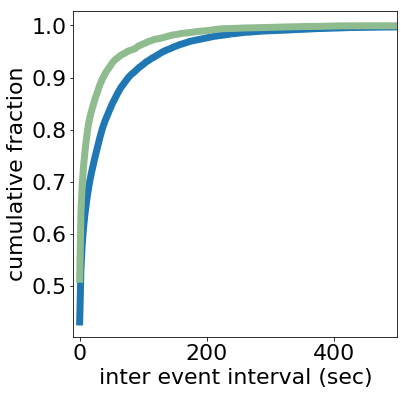

In [22]:
plt.rcParams.update({'font.size': 22})
plt.plot(np.linspace(0, 2000, 1000), wt_data, linewidth=7.0)
plt.plot(np.linspace(0, 2000, 1000), ko_data, color='darkseagreen', linewidth=7.0)
plt.xlim((-10, 500))
fig = plt.gcf()
fig.set_size_inches(6, 6)
ax = plt.gca()
ax.set_ylabel('cumulative fraction')
ax.set_xlabel('inter event interval (sec)')
fig.subplots_adjust(left=0.15)
fig.savefig('/home/jma819/presentation_files/wt_event_ISIs.pdf', transparent=True)
plt.show()

In [23]:
stats.ks_2samp(wt_data, ko_data)

Ks_2sampResult(statistic=0.302, pvalue=1.222371081395849e-40)

## velocity events 

In [24]:
len(ISIs)

NameError: name 'ISIs' is not defined

In [25]:
v_zscored = stats.zscore(V_df['tail_base'].values)

sample_points = ma.count_events_in_array(v_zscored, 20, .1, threshold=4, up=True)[1]
event_times = ([(1/5)*x for x in sample_points])
ISIs = [(event_times[event]-event_times[event-1]) for event in range(1, len(event_times))]

np.max(ISIs)

V_ISIs = stats.cumfreq(ISIs, numbins=200, defaultreallimits=(0, 5000))
V_ISIs_wt = V_ISIs.cumcount/len(ISIs)

In [26]:
ko_V_data = np.genfromtxt('/projects/p30771/miniscope/analysis/OpenFieldAnalysis/ko_velocity_ISIs.txt')

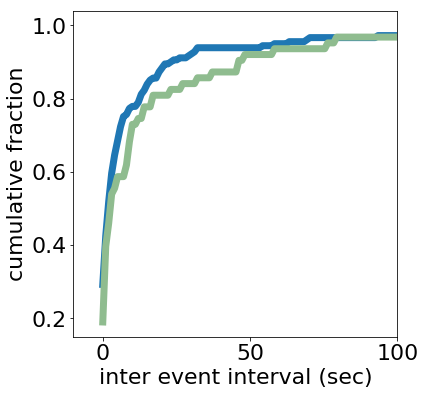

In [27]:
plt.rcParams.update({'font.size': 22})
plt.plot(np.linspace(0, 200, 200), V_ISIs_wt, linewidth=7.0)
plt.plot(np.linspace(0, 200, 200), ko_V_data, color='darkseagreen', linewidth=7.0)
plt.xlim((-10, 100))
fig = plt.gcf()
fig.set_size_inches(6, 6)
ax = plt.gca()
ax.set_ylabel('cumulative fraction')
ax.set_xlabel('inter event interval (sec)')
fig.subplots_adjust(left=0.15)
fig.savefig('/home/jma819/presentation_files/wt_V_ISIs.pdf', transparent=True)
plt.show()

In [28]:
stats.ks_2samp(V_ISIs_wt, ko_V_data)

Ks_2sampResult(statistic=0.48, pvalue=3.1330954373417528e-21)